## Importing required libraries

In [125]:
import pandas as pd
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pylab as pylab
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode
import pickle
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.pipeline import Pipeline






## Reading Data

In [126]:
df=pd.read_csv("Verbatims-20131231.csv")

In [5]:
df.head(5)

,Survey,Sequence8,Completed On,Name,City,Question Code,Verbatim
0,2013 NVES,16176609,20130815,Marco D.,NaN,NVES4001,"Great vehicle, but the dealer took way too lon..."
1,2013 NVES,16206634,20130815,Judith M.,NaN,NVES4001,LOVE electric vehicle--especially the fiat
2,2013 NVES,16161488,20130815,Alejandro G.,NaN,NVES4001,I love my jeep
3,2013 NVES,16168068,20130815,Beth S.,NaN,NVES4000,I wanted to get something with better fuel eco...
4,2013 NVES,16168068,20130815,Beth S.,NaN,NVES4001,The Jeep Compass needs additional interior sto...


## Finding the number of unique counts in each column

In [6]:
df.nunique()

Survey               1
Sequence8        19255
Completed On       250
Name              9461
City                 0
Question Code        3
Verbatim         26929
dtype: int64

## Droping (Survey,City,Sequence) columns from data

In [127]:
df=df.drop(['Survey','City','Sequence8'],axis=1)

In [8]:
df.describe(include='all')

,Completed On,Name,Question Code,Verbatim
count,2.726000e+04,27260,27260,27260
unique,NaN,9461,3,26929
top,NaN,John S.,NVES4001,Too expensive
freq,NaN,86,12590,43
mean,2.013123e+07,NaN,NaN,NaN
std,1.915598e+03,NaN,NaN,NaN
min,2.013052e+07,NaN,NaN,NaN
25%,2.013070e+07,NaN,NaN,NaN
50%,2.013083e+07,NaN,NaN,NaN
75%,2.013100e+07,NaN,NaN,NaN


## Replacing the column names

In [128]:
df.columns=['date','name','question_code','text']

## Extracting year from date

In [129]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['year']=df['date'].dt.year

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27260 entries, 0 to 27259
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           27260 non-null  datetime64[ns]
 1   name           27260 non-null  object        
 2   question_code  27260 non-null  object        
 3   text           27260 non-null  object        
 4   year           27260 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.0+ MB


## Checking null values

In [12]:
count=round(df.isnull().sum(),2)
percent=round((df.isnull().sum()/df.shape[0])*100,2)
data=pd.concat([count,percent],axis=1)
data.reset_index(inplace=True)
data.rename(columns={0: 'Missing Values Count',1: 'Missing Values %'},inplace=True)
data[data['Missing Values Count']!=0]

,index,Missing Values Count,Missing Values %


In [130]:
df.replace(to_replace =["NVES4001", "NVES4002","NVES4000"], 
                            value =["4001","4002","4000"])

,date,name,question_code,text,year
0,2013-08-15,Marco D.,4001,"Great vehicle, but the dealer took way too lon...",2013
1,2013-08-15,Judith M.,4001,LOVE electric vehicle--especially the fiat,2013
2,2013-08-15,Alejandro G.,4001,I love my jeep,2013
3,2013-08-15,Beth S.,4000,I wanted to get something with better fuel eco...,2013
4,2013-08-15,Beth S.,4001,The Jeep Compass needs additional interior sto...,2013
...,...,...,...,...,...
27255,2013-10-14,Jerry M.,4002,Just as happy as you can be...,2013
27256,2013-10-25,Waldemar D.,4002,Road noise is worse then my 2006 Honda Civic. ...,2013
27257,2013-10-15,Mary M.,4002,I have noticed that I some times get alert mes...,2013
27258,2013-10-22,Julie H.,4002,I am extremely unhappy with the gas mileage th...,2013


## Data cleaning on text column

In [131]:
#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

cleaned = lambda x: text_clean(x)

In [132]:
df['text'] = pd.DataFrame(df.text.apply(cleaned))

In [133]:
df.head()

,date,name,question_code,text,year
0,2013-08-15,Marco D.,NVES4001,great vehicle but the dealer took way too long...,2013
1,2013-08-15,Judith M.,NVES4001,love electric vehicleespecially the fiat,2013
2,2013-08-15,Alejandro G.,NVES4001,i love my jeep,2013
3,2013-08-15,Beth S.,NVES4000,i wanted to get something with better fuel eco...,2013
4,2013-08-15,Beth S.,NVES4001,the jeep compass needs additional interior sto...,2013


## Finding the sentiment of each data

In [134]:
df['sentiment'] = df['text'].apply(lambda x: 'positive' if(TextBlob(x).sentiment.polarity>0.2) else 'negative')

In [135]:
df.head()

,date,name,question_code,text,year,sentiment
0,2013-08-15,Marco D.,NVES4001,great vehicle but the dealer took way too long...,2013,negative
1,2013-08-15,Judith M.,NVES4001,love electric vehicleespecially the fiat,2013,positive
2,2013-08-15,Alejandro G.,NVES4001,i love my jeep,2013,positive
3,2013-08-15,Beth S.,NVES4000,i wanted to get something with better fuel eco...,2013,positive
4,2013-08-15,Beth S.,NVES4001,the jeep compass needs additional interior sto...,2013,negative


## Extracting the text column containing a keyword

In [148]:
rslt_df=pd.DataFrame()
rslt_df = df.text[df.text.str.contains('jeep compass')]
rslt_df=pd.merge(rslt_df,df,how='left').drop(columns= ['date', 'name', 'year'])
rslt_df.head()

,text,question_code,sentiment
0,the jeep compass needs additional interior sto...,NVES4001,negative
1,the jeep compass had more favorable lease options,NVES4000,positive
2,except that i love my jeep compass and the dea...,NVES4001,positive
3,it would be nice if the jeep compass comes wit...,NVES4001,negative
4,ive driven chrysler for many years and wanted ...,NVES4000,positive


## Extracting columns based on names

In [154]:
name_df=pd.DataFrame()
name_df = df.text[df.name.str.contains('John S')]
name_df=pd.merge(name_df,df,how='left').drop(columns= ['date', 'year'])
name_df.head(10)

,text,name,question_code,sentiment
0,i love the grand cherokee it is truly an exce...,John S.,NVES4001,positive
1,no stow and go,John S.,NVES4000,negative
2,no stow and go,Teresa S.,NVES4000,negative
3,this is our fifth dodgechrysler minivan we lo...,John S.,NVES4001,positive
4,i have owned pick ups before\rdown side is ver...,John S.,NVES4000,positive
5,wanted fuel economysleek style interior roomy ...,John S.,NVES4000,positive
6,nice design but no cd playerno protective side...,John S.,NVES4001,positive
7,the fact that consumer reports gave the honda ...,John S.,NVES4001,positive
8,this is our third honda pilot and the it i...,John S.,NVES4001,positive
9,price too high for what the vehicle offers\rde...,John S.,NVES4000,negative


## Checking the percentage of positive and negative sentiments

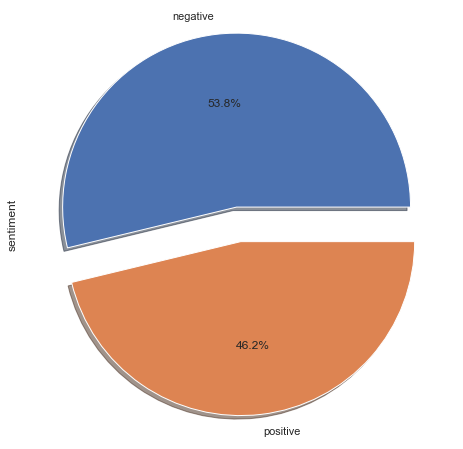

In [63]:
df['sentiment'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,figsize=(10,8))
plt.show()

In [34]:
pos_messages = df[df["sentiment"] == "positive"]["text"]
neg_messages = df[df["sentiment"] == "negative"]["text"]

## Checking most positive words

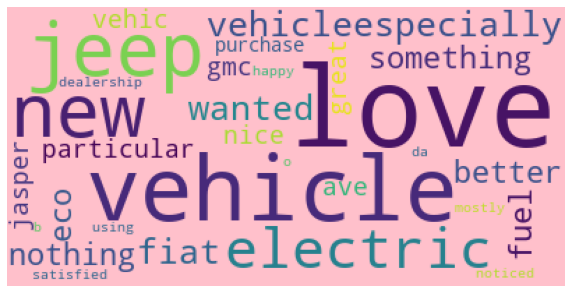

In [19]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="pink").generate(str(pos_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Checking most negative words

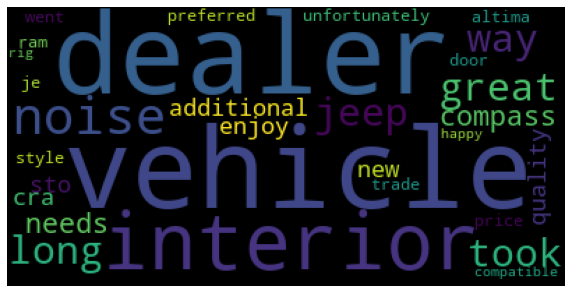

In [28]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="black").generate(str(neg_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Checking Which year has most sentiments

Text(0.5, 1.0, 'plotting year')

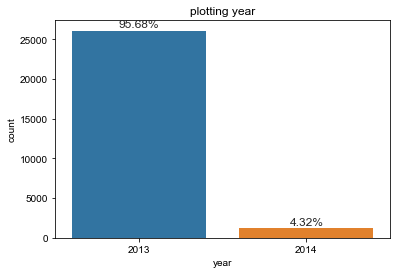

In [18]:
def barplot(column,data):
    bar_plot1=sns.countplot(x=column,data=data)
   
    total=len(data[column])
    for p in bar_plot1.patches:
        percentage='{:.2f}%'.format(100*p.get_height()/total)
        height=p.get_height()
        sns.set(style="darkgrid")
        bar_plot1.text(p.get_x()+p.get_width()/2,height+400,percentage,ha='center')
barplot('year',df)
plt.title('plotting year')

## Checking the positive and negative sentiments in each year

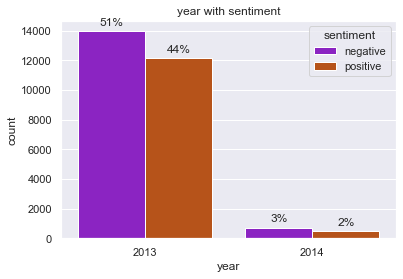

In [46]:
def barplot(column,data):
    bar_plot1=sns.countplot(x=column,data=data,hue='sentiment',palette="gnuplot")
   
    total=len(data[column])
    for p in bar_plot1.patches:
        percentage='{:.0f}%'.format(100*p.get_height()/total)
        height=p.get_height()
        sns.set(style="darkgrid",palette='deep')
        bar_plot1.text(p.get_x()+p.get_width()/2,height+400,percentage,ha='center')
        plt.title('year with sentiment')
barplot('year',df)

## Checking Most occuring dates and there counts

In [39]:
df['temp_date'] = df['date'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_date'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['temp_date','count']
temp.style.background_gradient(cmap='Blues')

,temp_date,count
0,00:00:00,27260
1,2013-08-21,837
2,2013-09-18,730
3,2013-10-01,717
4,2013-09-24,677
5,2013-08-20,666
6,2013-05-24,623
7,2013-08-22,577
8,2013-06-30,534
9,2013-08-19,516


In [41]:
fig = px.bar(temp, x="count", y="temp_date", title='most common dates', orientation='h', 
             width=700, height=700,color='temp_date')
fig.show()

In [137]:
ax= px.treemap(df,path=["date"])
ax.show()

## Dates with sentiments

In [62]:
ax= px.treemap(df,path=["date",'sentiment'],color='sentiment')
ax.show()

## Distribution of names

In [59]:
df['name'].iplot(kind='hist', xTitle='name',
                  yTitle='count', title='Claps Distribution')

## Percentage of each questioncode

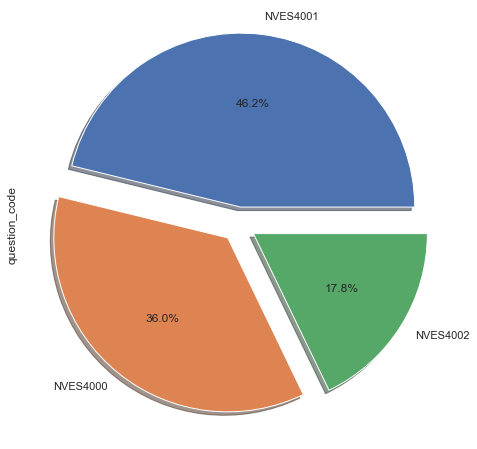

In [65]:
df['question_code'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',shadow=True,figsize=(10,8))
plt.show()

## Questioncode with sentiment

In [64]:
ax= px.treemap(df,path=["question_code",'sentiment'],color='sentiment')
ax.show()

# Model Building

In [31]:
Independent_var = df.text
Dependent_var = df.sentiment

IV_train, IV_test, DV_train, DV_test = train_test_split(Independent_var, Dependent_var, test_size = 0.1, random_state = 225)

print('IV_train :', len(IV_train))
print('IV_test  :', len(IV_test))
print('DV_train :', len(DV_train))
print('DV_test  :', len(DV_test))

IV_train : 24534
IV_test  : 2726
DV_train : 24534
DV_test  : 2726


## 1.Logistic Regression

In [32]:
tvec = TfidfVectorizer()
clf1 = LogisticRegression(solver = "lbfgs")

In [33]:
logit = Pipeline([('vectorizer',tvec),('classifier',clf1)])
logit.fit(IV_train, DV_train)
predictions = logit.predict(IV_test)
confusion_matrix(predictions, DV_test)

array([[1393,  176],
       [  92, 1065]], dtype=int64)

In [34]:
print("Accuracy for logistic: ", accuracy_score(predictions, DV_test))
print("Precision for logistic : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall for logistic : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy for logistic:  0.9016874541452677
Precision for logistic :  0.9041485447558698
Recall for logistic :  0.9016874541452677


## 2.Naive bayes

In [124]:
clf2=MultinomialNB()
NB = Pipeline([('vectorizer',tvec),('classifier',clf2)])
NB.fit(IV_train, DV_train)
predictions = NB.predict(IV_test)
confusion_matrix(predictions, DV_test)

array([[1298,  314],
       [ 187,  927]], dtype=int64)

In [125]:
print("Accuracy for NB: ", accuracy_score(predictions, DV_test))
print("Precision for NB : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall for NB : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy for NB:  0.8162142333088774
Precision for NB :  0.8221354257159524
Recall for NB :  0.8162142333088774


## 3.SVM

In [130]:
SVM = svm.SVC(kernel='linear')
SVM = Pipeline([('vectorizer',tvec),('classifier',clf2)])
SVM.fit(IV_train, DV_train)
predictions = SVM.predict(IV_test)
confusion_matrix(predictions, DV_test)

array([[1298,  314],
       [ 187,  927]], dtype=int64)

In [129]:
print("Accuracy for SVM: ", accuracy_score(predictions, DV_test))
print("Precision for SVM : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall for SVM : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy for SVM:  0.8162142333088774
Precision for SVM :  0.8221354257159524
Recall for SVM :  0.8162142333088774


## Predicting

In [19]:
example = ["extremely unhappy with the gas mileage that the car gets.  The salesman's selling point of the vehicle was the sticker and the gas mileage it is expected to get.  I have talked to the service department and they have no answers as to why it would be so low.   My main focus on buying a new car was gas mileage and in my opinion this car has failed my expectation and the sticker in the window."]
result = logit.predict(example)

In [20]:
print(result)

['negative']


## Checking top most common words and their counts

In [21]:
df['temp_list'] = df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,55008
1,i,32519
2,and,24951
3,to,23636
4,a,20516
5,was,14010
6,my,13192
7,it,12857
8,is,11836
9,of,11274


## bar plot of common words

In [25]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [23]:
import nltk
from nltk.corpus import stopwords

In [24]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
df['temp_list'] = df['temp_list'].apply(lambda x:remove_stopword(x))


## Checking top most common words and their counts without stopwords

In [26]:
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,vehicle,5642
2,dealership,4688
3,would,4235
4,new,4194
5,like,4041
6,love,4021
7,great,3288
8,experience,2977
9,one,2549
10,honda,2433


In [27]:
Positive_sent = df[df['sentiment']=='positive']
Negative_sent = df[df['sentiment']=='negative']

## Checking top most common positive words

In [28]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,car,4269
1,love,3163
2,great,2850
3,vehicle,2483
4,dealership,2437
5,new,2159
6,experience,1896
7,would,1662
8,better,1547
9,good,1485


## Bar plot of all positive common words

In [29]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()


## Checking top most common negative words

In [30]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,vehicle,3159
2,like,2591
3,would,2573
4,dealership,2251
5,new,2035
6,get,1580
7,back,1503
8,one,1494
9,dealer,1451
10,wanted,1348


## Bar plot of top negative words

In [31]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

## Hybrid model

In [43]:
Postive_pattern_1 = r"car"
Postive_pattern_2 = r"nice"
Postive_pattern_3 = r"love"
Postive_pattern_4 = r"good"
Postive_pattern_5 = r"safe"
Postive_pattern_6 = r"awesome"
Postive_pattern_7 = r"new"
Postive_pattern_8 = r"satisfied"
Postive_pattern_9 = r"great"


Positive_Pattern_List = [Postive_pattern_1,Postive_pattern_2,Postive_pattern_3,Postive_pattern_4,
                        Postive_pattern_5,Postive_pattern_6,Postive_pattern_7,Postive_pattern_8]

In [44]:
Positive_Complex_Pattern = re.compile('|'.join(['(%s)' % i for i in Positive_Pattern_List]),re.IGNORECASE)

In [45]:
Negative_pattern_1 = r"dealer"
Negative_pattern_2 = r"needs"
Negative_pattern_3 = r"long"
Negative_pattern_4 = r"additional"
Negative_pattern_5 = r"trade"
Negative_pattern_6 = r"worst"
Negative_pattern_7 = r"unfortunately"
Negative_pattern_8 = r"never"
Negative_pattern_9 = r"interior"

Negative_Pattern_List = [Negative_pattern_1,Negative_pattern_2,Negative_pattern_3,Negative_pattern_4,
                        Negative_pattern_5,Negative_pattern_6,Negative_pattern_7,Negative_pattern_8]

In [46]:
Negative_Complex_Pattern = re.compile('|'.join(['(%s)' % i for i in Negative_Pattern_List]),re.IGNORECASE)

In [47]:
df["Negative_Sentiment_Flag"] = df["text"].apply(lambda x:1 if(len(re.findall(Negative_Complex_Pattern,x))>0) else 0)

In [48]:
df["Positive_Sentiment_Flag"] = df["text"].apply(lambda x:1 if(len(re.findall(Positive_Complex_Pattern,x))>0) else 0)

In [59]:
df.head()

,date,name,question_code,text,year,sentiment,Negative_Sentiment_Flag,Positive_Sentiment_Flag
0,2013-08-15,Marco D.,NVES4001,great vehicle but the dealer took way too long...,2013,negative,1,1
1,2013-08-15,Judith M.,NVES4001,love electric vehicleespecially the fiat,2013,positive,0,0
2,2013-08-15,Alejandro G.,NVES4001,i love my jeep,2013,positive,0,0
3,2013-08-15,Beth S.,NVES4000,i wanted to get something with better fuel eco...,2013,positive,0,0
4,2013-08-15,Beth S.,NVES4001,the jeep compass needs additional interior sto...,2013,negative,1,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df[["text","Negative_Sentiment_Flag","Positive_Sentiment_Flag"]],df["sentiment"],test_size=0.1,shuffle=True)

In [50]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True,max_features = 10)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train["text"]) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test["text"])

In [51]:
mydf = pd.DataFrame(X_train_vectors_tfidf.toarray())
mydf_test = pd.DataFrame(X_test_vectors_tfidf.toarray())

In [52]:
flag_columns_train = X_train[["Negative_Sentiment_Flag","Positive_Sentiment_Flag"]]
flag_columns_test = X_test[["Negative_Sentiment_Flag","Positive_Sentiment_Flag"]]

In [53]:
X_train_vectors_tfidf_combined_with_flag = pd.concat([mydf.reset_index(drop=True),flag_columns_train.reset_index(drop=True)],axis=1)

In [54]:
X_test_vectors_tfidf_combined_with_flag = pd.concat([mydf_test.reset_index(drop=True),flag_columns_test.reset_index(drop=True)],axis=1)

In [55]:
lr_tfidf=LogisticRegression(solver = "lbfgs")
lr_tfidf.fit(X_train_vectors_tfidf_combined_with_flag, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf_combined_with_flag)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf_combined_with_flag)[:,1]
confusion_matrix(y_predict, y_test)

array([[1034,  532],
       [ 438,  722]], dtype=int64)

In [56]:
print("Accuracy for HB: ", accuracy_score(y_predict, y_test))
print("Precision for HB : ", precision_score(y_predict, y_test, average = 'weighted'))
print("Recall for HB : ", recall_score(y_predict, y_test, average = 'weighted'))

Accuracy for HB:  0.6441672780630961
Precision for HB :  0.6485358324222803
Recall for HB :  0.6441672780630961


## Pickling the model

In [ ]:
with open('model.pkl','wb')as f:
    pickle.dump(logit,f)
    

In [147]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

ImportError: Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [146]:
!pip install keras --upgrade --force-reinstall

ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 3.3.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.1 which is incompatible.
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.



  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.3.1
